# Time Series Forecasting with Machine Learning

This notebook explores time series forecasting using traditional feature engineering and machine learning models. We transform date-time features, create lag-based predictors, and apply regression models to capture temporal patterns in the data. The goal is to predict future values based on historical observations and derived features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

color_pal=sns.color_palette()
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df=pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)

## Data Overview

We begin by loading the dataset and examining its structure. The dataset consists of timestamped values, which form the foundation for time series forecasting. Exploratory analysis helps in identifying trends, seasonality, and any anomalies in the data.


<Axes: title={'center': 'PJME Energy use in MW'}, xlabel='Datetime'>

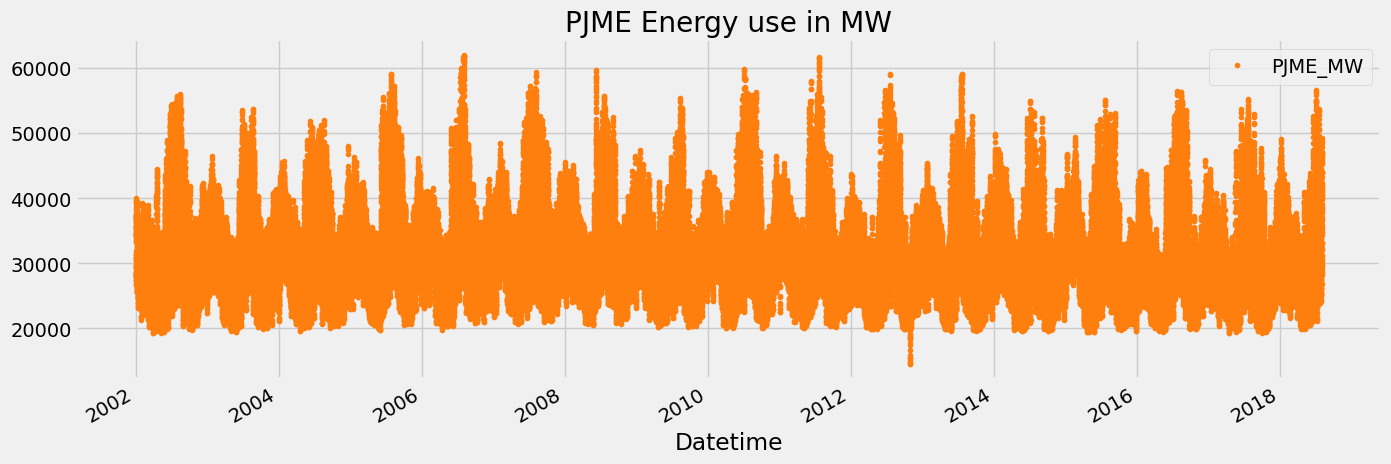

In [3]:
df.plot(style='.',
        figsize=(15,5),
        color=color_pal[1],
        title='PJME Energy use in MW')

# Train / Test Split

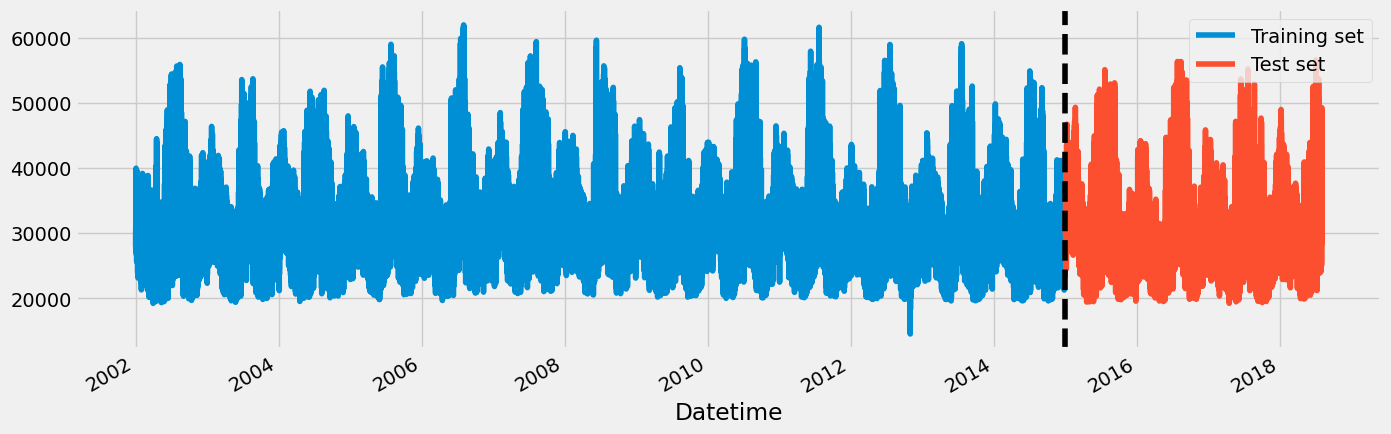

In [4]:
train=df.loc[df.index < '01-01-2015']

test=df.loc[df.index >= '01-01-2015']

fig,ax=plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['Training set','Test set'])
plt.show()

## Train-Test Split

The dataset is divided into training and testing sets based on time. The training set contains earlier data points, while the testing set simulates unseen future data.  
This ensures that model evaluation reflects real-world forecasting performance.


<Axes: xlabel='Datetime'>

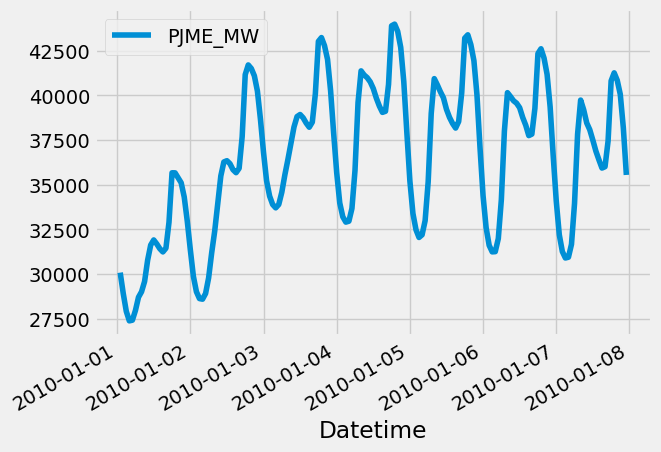

In [5]:
df.loc[(df.index>'01-01-2010')&(df.index<'01-08-2010')].plot()

# Feature Creation

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df=df.copy()
    df['hour']= df.index.hour
    df['dayofweek']=df.index.day_of_week
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofyear']=df.index.dayofyear
    return df

df=create_features(df)

## Feature Engineering

To make the data suitable for machine learning models, we extract additional features from the datetime column such as **year, month, day, weekday, and hour**.  
Lag features (previous values of the series) are also introduced, allowing the model to learn from past behavior and capture temporal dependencies.


# Visualize our Feature / Target Relationship

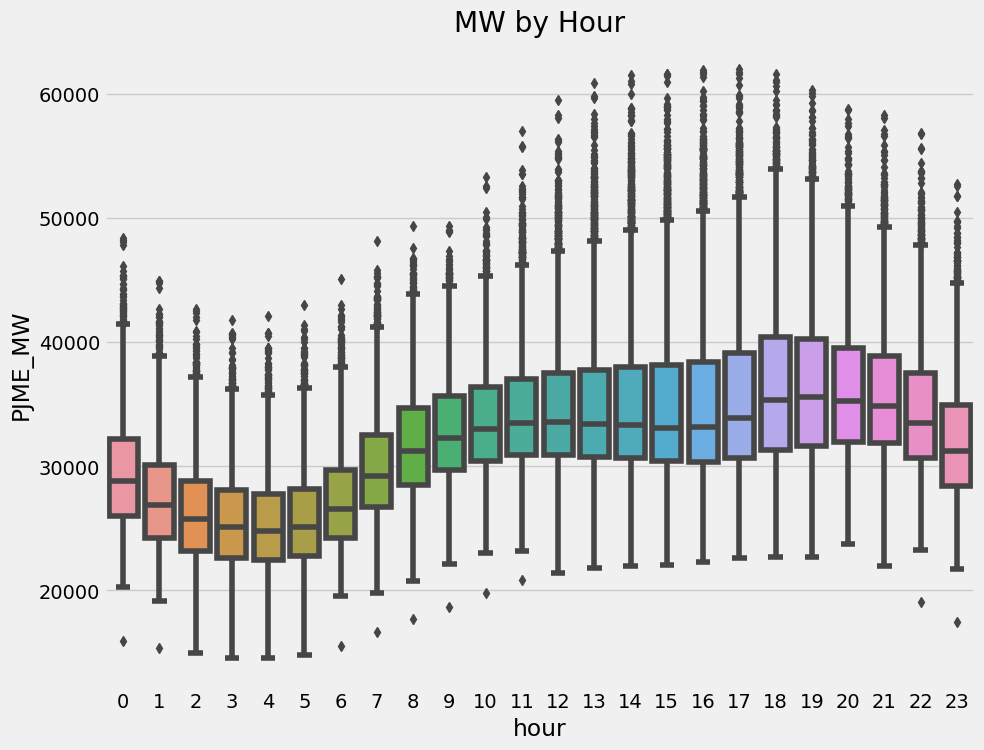

In [7]:
fig, ax =plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='hour',y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

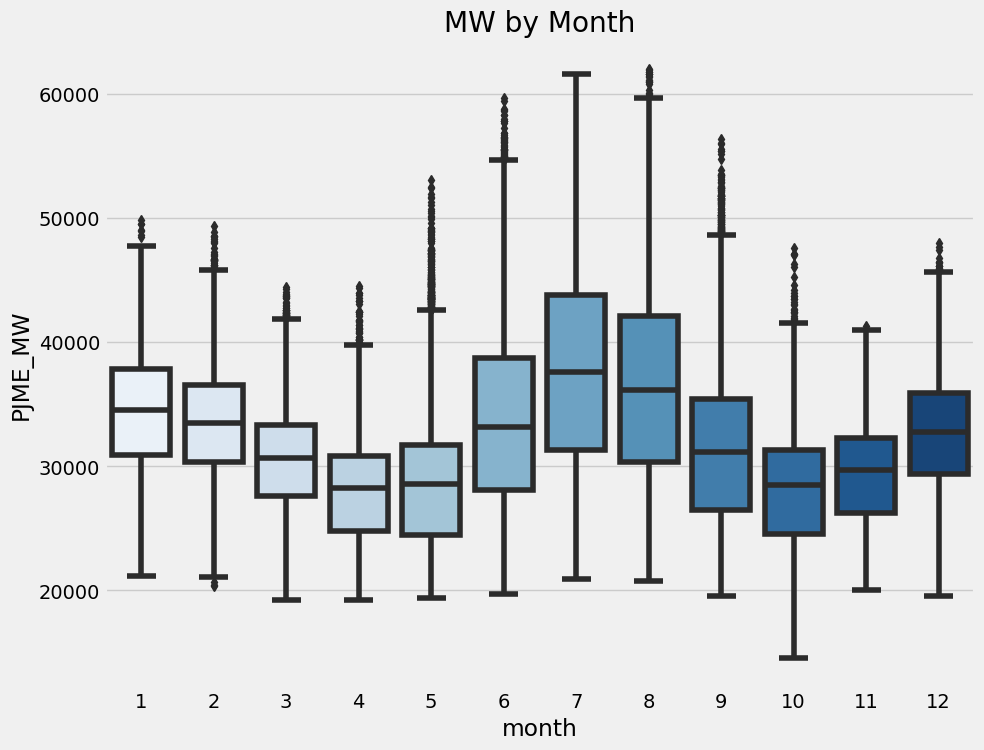

In [8]:
fig, ax =plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='month',y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Creating our Model

In [9]:
train=create_features(train)
test=create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
TARGET = 'PJME_MW'

In [10]:
X_train=train[FEATURES]
y_train=train[TARGET]

X_test=test[FEATURES]
y_test=test[TARGET]

In [11]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                      learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test,y_test)],
        verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Model Training and Forecasting

We apply machine learning regression models to the prepared features. These models attempt to map engineered features and lagged values to future outcomes.  
The trained model generates predictions on the test set, which are compared with actual values to assess accuracy.


# Feature Importance

In [12]:
fi=pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

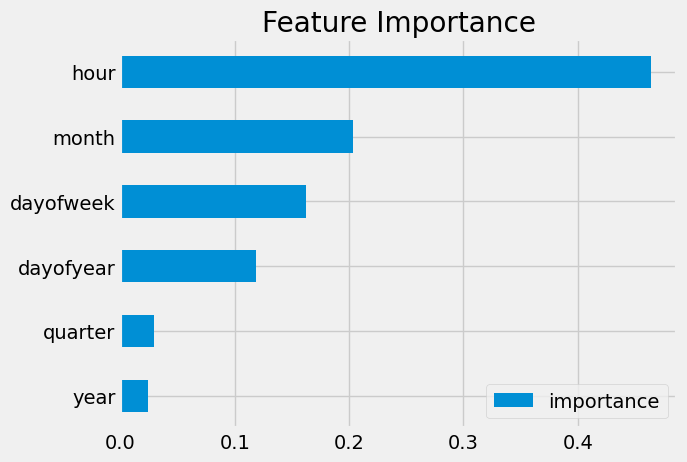

In [13]:
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()

# Forecast on Test

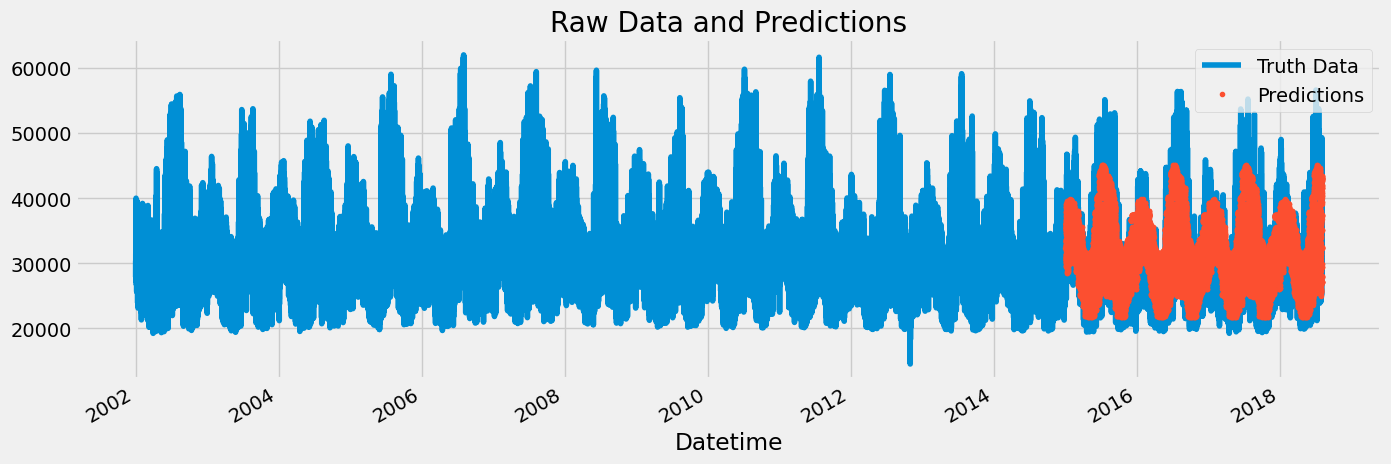

In [14]:
test['prediction']=reg.predict(X_test)
df=df.merge(test[['prediction']], how='left',left_index=True, right_index=True)
ax=df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='.')
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

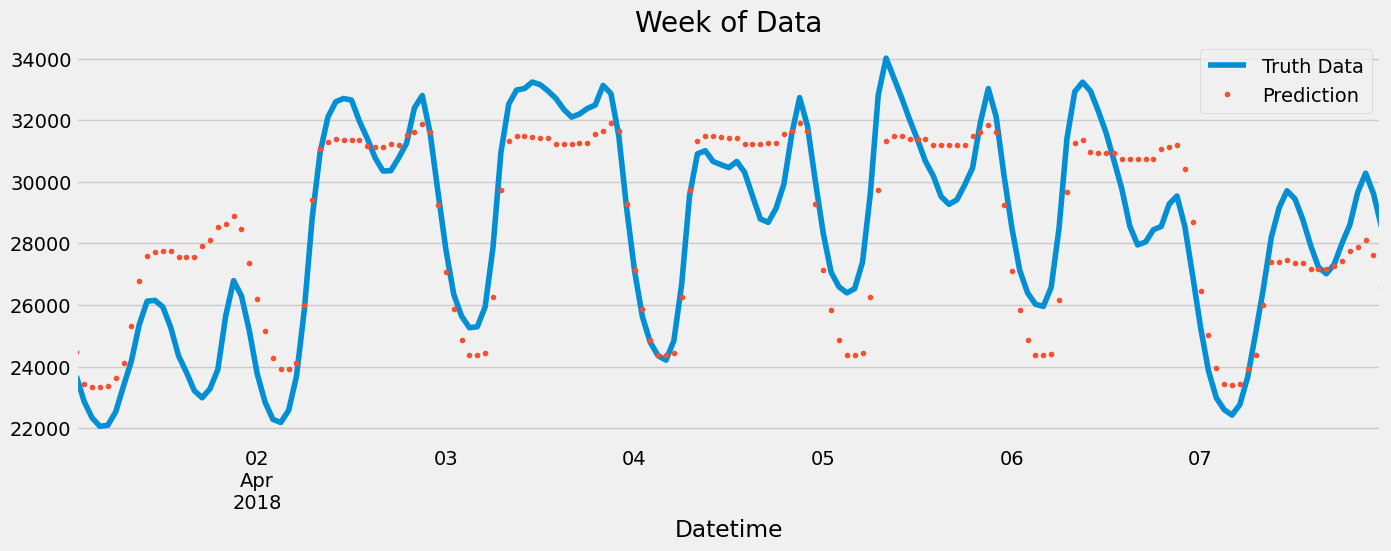

In [15]:
ax= df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15,5), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Results and Visualizations

The comparison between actual and predicted values shows how well the model captures underlying trends.  
Visualization highlights the alignment (or deviation) between predictions and true values, giving insights into strengths and weaknesses of the approach.


In [16]:
score=np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3741.03


# Calculate Error
- Look at the worst and best predicted days

Worst Predictions

In [17]:
test['error']=np.abs(test[TARGET]-test['prediction'])
test['date']=test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

Best predictions

In [18]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64

## Conclusion and Future Work

- The model successfully learns patterns in the time series using feature engineering and regression.  
- Predictions follow the general trend, though some deviations are observed during highly variable periods.  

### Future Scope:
- Incorporating more sophisticated models such as **ARIMA, Prophet, LSTMs, or Transformers**.  
- Enhancing feature engineering with rolling statistics, Fourier terms for seasonality, or external covariates (e.g., holidays, weather).  
- Hyperparameter tuning and cross-validation for more robust results.  
- Extending the forecasting horizon and evaluating multi-step predictions.  
